In [2]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns
import math

from bisect import bisect_left
from bokeh.plotting import figure,show,output_notebook
from datetime import datetime
import xgboost as xgb
from bokeh.models import Range1d
from datetime import date

from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn import grid_search
from sklearn import cross_validation, metrics as mtrcs
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.kernel_approximation import RBFSampler,Nystroem
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA

from sklearn.svm import SVC

import holidays

sns.set_style("white")
sns.set_context("poster",font_scale=1.1)
output_notebook()
%matplotlib inline

BokehJS successfully loaded.

In [3]:
878049+884262

1762311

In [4]:
## get data

#train = pd.read_csv('..Data/train.csv')
#test = pd.read_csv('..Data/test.csv')

train = pd.read_csv('/home/ubuntu/Data/train.csv')
test = pd.read_csv('/home/ubuntu/Data/test.csv')

print 'train',len(train)
print 'test',len(test)

train['Id'] = train.index.values
train['Id'] = train['Id'].apply(lambda x:(884262+x))
train = train.set_index('Id',drop=True)
test = test.set_index('Id',drop=True)


train.info()
train.head()

train 878049
test 884262
<class 'pandas.core.frame.DataFrame'>
Int64Index: 878049 entries, 884262 to 1762310
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 67.0+ MB


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
Id,,,,,,,,,
884262,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
884263,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
884264,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
884265,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
884266,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [5]:
## make text readable
 
train.loc[:,'Category'] = train['Category'].apply(lambda x: x.title())
train.loc[:,'Descript'] = train['Descript'].apply(lambda x: x.title())
train.loc[:,'Resolution'] = train['Resolution'].apply(lambda x: x.title())

Baseline 0.199191616869


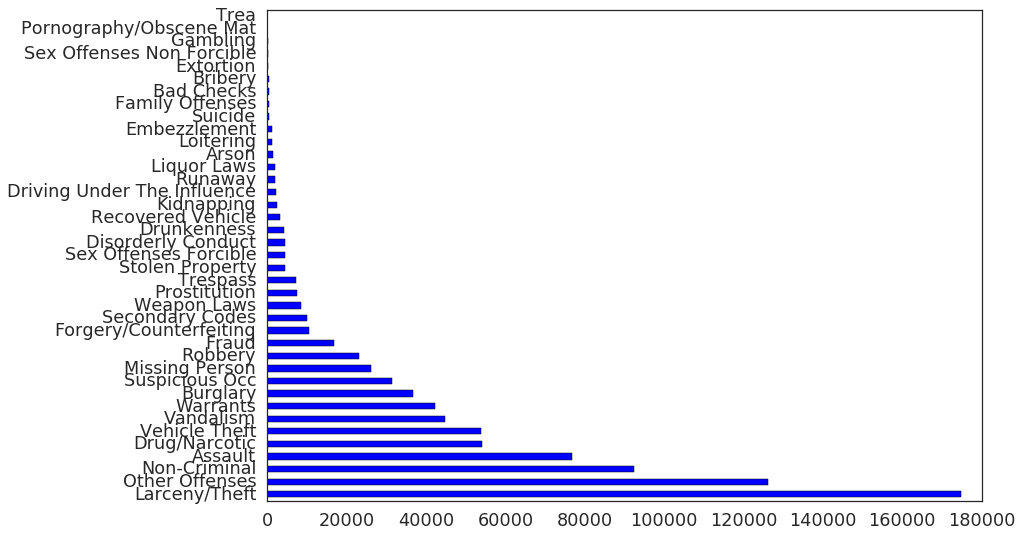

In [6]:
## plot value counts of Category

sns.set_style("white")
sns.set_context("poster",font_scale=1.1)

print 'Baseline',len(train[train.Category=='Larceny/Theft'])/float(len(train))

train.Category.value_counts().plot(kind='barh')

In [7]:
## combine train and test data 

traind = train.drop(['Category','Descript','Resolution'],axis=1)

traind = traind[test.columns]

train_index = train.index.values
test_index = test.index.values

all_crimes = pd.concat([traind,test],ignore_index=0)
all_crimes.info()
all_crimes.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1762311 entries, 884262 to 884261
Data columns (total 6 columns):
Dates         object
DayOfWeek     object
PdDistrict    object
Address       object
X             float64
Y             float64
dtypes: float64(2), object(4)
memory usage: 94.1+ MB


,Dates,DayOfWeek,PdDistrict,Address,X,Y
Id,,,,,,
884262,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599
884263,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599
884264,2015-05-13 23:33:00,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414
884265,2015-05-13 23:30:00,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-122.426995,37.800873
884266,2015-05-13 23:30:00,Wednesday,PARK,100 Block of BRODERICK ST,-122.438738,37.771541


In [8]:
## error coding on Y

# avg Y for PD district

y_by_district = all_crimes.groupby('PdDistrict').Y.mean()

all_crimes['Y'][all_crimes.Y==90] = all_crimes['PdDistrict'][all_crimes.Y==90].map(y_by_district)

# convert Dates to datetime64
all_crimes['Dates'] = pd.to_datetime(all_crimes['Dates'],format='%Y-%m-%d %H:%M:%S',errors='raise')

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
## feature engineering for dates

# date extraction

all_crimes['Year'] = all_crimes['Dates'].dt.year
all_crimes['Month'] = all_crimes['Dates'].dt.month
all_crimes['Day'] = all_crimes['Dates'].dt.day
all_crimes['Hour'] = all_crimes['Dates'].dt.hour
#all_crimes['Minute'] = all_crimes['Dates'].dt.minute
all_crimes['Weekday'] = all_crimes['Dates'].dt.weekday

# concatenate to get more time movements

#all_crimes['Year-Month'] = all_crimes['Year'].map(str) + '-' + all_crimes['Month'].map(str)
#all_crimes['Month-Day'] = all_crimes['Month'].map(str) + '-' + all_crimes['Day'].map(str)
#all_crimes['Day-Hour'] = all_crimes['Day'].map(str) + '-' + all_crimes['Hour'].map(str)


# isweekend

def IsWeekend(day):
    if day in [5,6]:
        return 1
    return 0

all_crimes['IsWeekend'] = all_crimes['Weekday'].apply(IsWeekend)   
    
    
# season    
    
def Season(d):
    if d in [12,1,2]:
        return "Winter"
    elif d in [3,4,5]:
        return "Spring"
    elif d in [6,7,8]:
        return "Summer"
    elif d in [9,10,11]:
        return "Fall"

all_crimes['Season'] = all_crimes['Month'].apply(Season) 


# use hour to determine if crime occurred at night

def IsNight(h):
    if h in range(20,24)+range(0,6):
        return 1
    return 0

all_crimes['IsNight'] = all_crimes['Hour'].apply(IsNight)    


# distance from holidays

CA_Holidays = holidays.US(state='CA', years=range(2003,2016)).items()

for y in range(2003,2016):
    CA_Holidays.append((date(y, 10, 31), 'Halloween'))
    CA_Holidays.append((date(y, 2, 14), 'Valentine\'s Day'))

holidays_df = pd.DataFrame(sorted(CA_Holidays),columns=['Date','Holiday'])
holidays_df['Date'] = pd.to_datetime(holidays_df['Date'],format='%Y-%m-%d',errors='raise')

to_exclude = ['Lincoln\'s Birthday','César Chávez Day','Washington\'s Birthday','Susan B. Anthony Day']

holidays_df = holidays_df[~holidays_df.Holiday.isin(to_exclude)]

s = list(holidays_df['Date'])

def nearest(ts):
    # Given a presorted list of timestamps:  s = sorted(index)
    i = bisect_left(s, ts)
    near = min(s[max(0, i-1): i+2], key=lambda t: abs(ts - t))
    return abs((ts - near).total_seconds()/(60*60*24))

all_crimes['days_from_holiday'] = all_crimes['Dates'].apply(nearest)
    

In [10]:
## feature creation on address

# street type

convert_st = {'AY':'WY','80':'HY','ER':'TR','MS':'AV',
              'AR':'BL','EX':'AV','RK':'ST','WK':'ST',
              'RW':'ST',' /':'ST','NO':'ST','TI':'ST'}

def StreetType(s):
    if '/' in s:
        return 'CNR'
    
    slc = s[-2:]
    
    if slc in convert_st.keys():
        return convert_st[slc]
    return s[-2:]

all_crimes['street_type'] = all_crimes['Address'].apply(StreetType)


# crimes at intersections

def IsCorner(s):
    if "/" in s:
        return 1
    return 0

all_crimes['IsCorner'] = all_crimes['Address'].apply(IsCorner)





In [11]:
## feature creation on coordinates

# convert to polar coordinates

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (rho, phi)

all_crimes[['rho','phi']] = all_crimes[['X','Y']].apply(lambda (x,y):list(cart2pol(x, y)),axis=1)


# rotate coordinates

def rotate(x, y,t):
    xr = x*np.cos(t) - y*np.sin(t)
    yr = y*np.cos(t) + x*np.sin(t)
    return (xr,yr)

all_crimes[['X_30','Y_30']] = all_crimes[['X','Y']].apply(lambda (x,y):list(rotate(x,y,30)),axis=1)
all_crimes[['X_60','Y_60']] = all_crimes[['X','Y']].apply(lambda (x,y):list(rotate(x,y,60)),axis=1)
all_crimes[['X_90','Y_90']] = all_crimes[['X','Y']].apply(lambda (x,y):list(rotate(x,y,90)),axis=1)



In [12]:
### plot tableau

# crms = ['Arson', 'Assault', 'Bad Checks', 'Bribery', 'Burglary',
#        'Disorderly Conduct', 'Driving Under The Influence',
#        'Drug/Narcotic', 'Drunkenness', 'Embezzlement', 'Extortion',
#        'Family Offenses', 'Forgery/Counterfeiting', 'Fraud', 'Gambling',
#        'Kidnapping', 'Larceny/Theft', 'Liquor Laws', 'Loitering',
#        'Missing Person', 'Non-Criminal', 'Other Offenses',
#        'Pornography/Obscene Mat', 'Prostitution', 'Recovered Vehicle',
#        'Robbery', 'Runaway', 'Secondary Codes', 'Sex Offenses Forcible',
#        'Sex Offenses Non Forcible', 'Stolen Property', 'Suicide',
#        'Suspicious Occ', 'Trea', 'Trespass', 'Vandalism', 'Vehicle Theft',
#        'Warrants', 'Weapon Laws']


#plot_tableau = all_crimes.ix[train_index].join(train[['Category','Descript','Resolution']])
# plot_tableau.head()


# violent_crimes = ['Murder','Assault','']

In [13]:
# # crime type and is_corner

# sns.set_style("white")

# sns.set_context("poster",font_scale=1.1)

# measure = 'is_corner'

# plot_tableau.groupby('Category')[measure].mean().plot(title=measure,kind='barh',color='darksalmon')


In [14]:
all_crimes.head(5)

,Dates,DayOfWeek,PdDistrict,Address,X,Y,Year,Month,Day,Hour,...,street_type,IsCorner,rho,phi,X_30,Y_30,X_60,Y_60,X_90,Y_90
Id,,,,,,,,,,,,,,,,,,,,,
884262,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,...,CNR,1,128.121112,2.842310,18.438127,126.787439,-96.455552,-84.328795,128.114107,1.339694
884263,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,...,CNR,1,128.121112,2.842310,18.438127,126.787439,-96.455552,-84.328795,128.114107,1.339694
884264,2015-05-13 23:33:00,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23,...,CNR,1,128.127265,2.842114,18.463869,126.789911,-96.476716,-84.313933,128.120520,1.314641
884265,2015-05-13 23:30:00,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23,...,ST,0,128.129915,2.842116,18.463916,126.792582,-96.478488,-84.315932,128.123167,1.315007
884266,2015-05-13 23:30:00,Wednesday,PARK,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23,...,ST,0,128.132485,2.842362,18.433124,126.799660,-96.459699,-84.341332,128.125410,1.346522


# Model Building

### Prepare data for model

In [15]:
all_crimes.drop(['DayOfWeek','Address'],axis=1,inplace=True)

In [16]:
all_crimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1762311 entries, 884262 to 884261
Data columns (total 23 columns):
Dates                datetime64[ns]
PdDistrict           object
X                    float64
Y                    float64
Year                 int64
Month                int64
Day                  int64
Hour                 int64
Weekday              int64
IsWeekend            int64
Season               object
IsNight              int64
days_from_holiday    float64
street_type          object
IsCorner             int64
rho                  float64
phi                  float64
X_30                 float64
Y_30                 float64
X_60                 float64
Y_60                 float64
X_90                 float64
Y_90                 float64
dtypes: datetime64[ns](1), float64(11), int64(8), object(3)
memory usage: 322.7+ MB


In [17]:
cat_cols = []
cont_cols = []


for col in all_crimes:
    if (all_crimes[col].dtypes == 'int64') or (all_crimes[col].dtypes == 'object'):
        cat_cols.append(col)
    elif all_crimes[col].dtypes == 'float64':
        cont_cols.append(col)

print cat_cols
print cont_cols

['PdDistrict', 'Year', 'Month', 'Day', 'Hour', 'Weekday', 'IsWeekend', 'Season', 'IsNight', 'street_type', 'IsCorner']
['X', 'Y', 'days_from_holiday', 'rho', 'phi', 'X_30', 'Y_30', 'X_60', 'Y_60', 'X_90', 'Y_90']


In [18]:
## scale continuous columns

scaler = StandardScaler()

cat_df = all_crimes[cat_cols]
cont_df = all_crimes[cont_cols]
x_cont = scaler.fit_transform(cont_df)
X_cont = pd.DataFrame(x_cont, columns=cont_df.columns,index=cont_df.index)
X_cont.head()

,X,Y,days_from_holiday,rho,phi,X_30,Y_30,X_60,Y_60,X_90,Y_90
Id,,,,,,,,,,,
884262,-0.105527,0.313876,-0.206169,0.182170,-0.243095,0.280514,0.145376,-0.333965,0.040413,0.184877,-0.240439
884263,-0.105527,0.313876,-0.206169,0.182170,-0.243095,0.280514,0.145376,-0.333965,0.040413,0.184877,-0.240439
884264,-0.055688,1.381871,-0.205052,0.392593,-1.213171,1.312554,0.227636,-1.200538,0.528129,0.404627,-1.205874
884265,-0.141509,1.400831,-0.204884,0.483229,-1.200092,1.314430,0.316543,-1.273127,0.462528,0.495321,-1.191775
884266,-0.524343,0.187390,-0.204884,0.571122,0.015990,0.079967,0.552076,-0.503756,-0.370990,0.572180,0.022663


In [19]:
to_encode = []

for col in all_crimes:
    if all_crimes[col].dtypes == 'object':
        to_encode.append(col)
        
to_encode

['PdDistrict', 'Season', 'street_type']

In [20]:
## encode categorical columns

for c in cat_cols:
    le = LabelEncoder()
    le.fit(cat_df[c])
    cat_df[c] = le.transform(cat_df[c])
    #cat_df[c] = cat_df[c].astype('category')

cat_df.info()
cat_df.head(2)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1762311 entries, 884262 to 884261
Data columns (total 11 columns):
PdDistrict     int64
Year           int64
Month          int64
Day            int64
Hour           int64
Weekday        int64
IsWeekend      int64
Season         int64
IsNight        int64
street_type    int64
IsCorner       int64
dtypes: int64(11)
memory usage: 161.3 MB


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,PdDistrict,Year,Month,Day,Hour,Weekday,IsWeekend,Season,IsNight,street_type,IsCorner
Id,,,,,,,,,,,
884262,4,12,4,12,23,2,0,1,1,3,1
884263,4,12,4,12,23,2,0,1,1,3,1


In [21]:
cat_df_dummies = pd.concat([pd.get_dummies(cat_df[col],prefix=col,prefix_sep='-').iloc[:, 1:] for col in cat_df], axis=1)
cat_df_dummies.head(3)

,PdDistrict-1,PdDistrict-2,PdDistrict-3,PdDistrict-4,PdDistrict-5,PdDistrict-6,PdDistrict-7,PdDistrict-8,PdDistrict-9,Year-1,...,street_type-6,street_type-7,street_type-8,street_type-9,street_type-10,street_type-11,street_type-12,street_type-13,street_type-14,IsCorner-1
Id,,,,,,,,,,,,,,,,,,,,,
884262,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
884263,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
884264,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
x_all = cat_df_dummies.join(X_cont)
#x_all = cat_df.join(X_cont)
x_train = x_all.ix[train_index]

X_train = x_train.join(train['Category'])

le2 = LabelEncoder()
le2.fit(X_train['Category'])
print le2.classes_

X_train['Category'] = le2.transform(X_train['Category'])

X_train2 = X_train

y_train = X_train['Category']
X_train.drop('Category',inplace=True,axis=1)
X_train.head()

['Arson' 'Assault' 'Bad Checks' 'Bribery' 'Burglary' 'Disorderly Conduct'
 'Driving Under The Influence' 'Drug/Narcotic' 'Drunkenness' 'Embezzlement'
 'Extortion' 'Family Offenses' 'Forgery/Counterfeiting' 'Fraud' 'Gambling'
 'Kidnapping' 'Larceny/Theft' 'Liquor Laws' 'Loitering' 'Missing Person'
 'Non-Criminal' 'Other Offenses' 'Pornography/Obscene Mat' 'Prostitution'
 'Recovered Vehicle' 'Robbery' 'Runaway' 'Secondary Codes'
 'Sex Offenses Forcible' 'Sex Offenses Non Forcible' 'Stolen Property'
 'Suicide' 'Suspicious Occ' 'Trea' 'Trespass' 'Vandalism' 'Vehicle Theft'
 'Warrants' 'Weapon Laws']


,PdDistrict-1,PdDistrict-2,PdDistrict-3,PdDistrict-4,PdDistrict-5,PdDistrict-6,PdDistrict-7,PdDistrict-8,PdDistrict-9,Year-1,...,Y,days_from_holiday,rho,phi,X_30,Y_30,X_60,Y_60,X_90,Y_90
Id,,,,,,,,,,,,,,,,,,,,,
884262,0,0,0,1,0,0,0,0,0,0,...,0.313876,-0.206169,0.182170,-0.243095,0.280514,0.145376,-0.333965,0.040413,0.184877,-0.240439
884263,0,0,0,1,0,0,0,0,0,0,...,0.313876,-0.206169,0.182170,-0.243095,0.280514,0.145376,-0.333965,0.040413,0.184877,-0.240439
884264,0,0,0,1,0,0,0,0,0,0,...,1.381871,-0.205052,0.392593,-1.213171,1.312554,0.227636,-1.200538,0.528129,0.404627,-1.205874
884265,0,0,0,1,0,0,0,0,0,0,...,1.400831,-0.204884,0.483229,-1.200092,1.314430,0.316543,-1.273127,0.462528,0.495321,-1.191775
884266,0,0,0,0,1,0,0,0,0,0,...,0.187390,-0.204884,0.571122,0.015990,0.079967,0.552076,-0.503756,-0.370990,0.572180,0.022663


In [23]:
X_test = x_all.ix[test_index]
X_test.info()
X_test.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884262 entries, 0 to 884261
Columns: 122 entries, PdDistrict-1 to Y_90
dtypes: float64(122)
memory usage: 829.8 MB


,PdDistrict-1,PdDistrict-2,PdDistrict-3,PdDistrict-4,PdDistrict-5,PdDistrict-6,PdDistrict-7,PdDistrict-8,PdDistrict-9,Year-1,...,Y,days_from_holiday,rho,phi,X_30,Y_30,X_60,Y_60,X_90,Y_90
Id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,-1.322206,0.034862,-1.076000,0.917200,-1.123339,-0.922555,1.609724,0.093145,-1.086636,0.902056
1,0,0,0,0,0,0,0,0,0,0,...,-1.430538,0.035309,-1.365939,0.922084,-1.177192,-1.201182,1.874434,0.273196,-1.377188,0.903435


# Build Model

In [48]:
# tune xgboost

MODEL = xgb.XGBClassifier(objective='multi:softprob',
                          seed=157,
                          max_depth=5,
                          colsample_bytree=0.7,
                          subsample=0.8,
                          learning_rate=0.1,
                          min_child_weight=1,
                          scale_pos_weight=1,
                          max_delta_step=1
                         ) 

SCORING = 'accuracy'

PARAMS = {'n_estimators':[50,100,150,200]
         }

clf = grid_search.GridSearchCV(MODEL,
                               PARAMS,
                               verbose=True,
                               scoring=SCORING)

clf.fit(X_train.values, y_train.values)

print clf.best_estimator_
print clf.best_score_

#regalpha
# Fitting 3 folds for each of 7 candidates, totalling 21 fits
# XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.55,
#        gamma=0.2, learning_rate=0.1, max_delta_step=1, max_depth=2,
#        min_child_weight=5, missing=None, n_estimators=25, nthread=-1,
#        objective='multi:softprob', reg_alpha=100, reg_lambda=1,
#        scale_pos_weight=1, seed=157, silent=True, subsample=0.75)
# -2.92249091876

#reglambda
# Fitting 3 folds for each of 7 candidates, totalling 21 fits
# XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.55,
#        gamma=0.2, learning_rate=0.1, max_delta_step=1, max_depth=2,
#        min_child_weight=5, missing=None, n_estimators=25, nthread=-1,
#        objective='multi:softprob', reg_alpha=100, reg_lambda=100,
#        scale_pos_weight=1, seed=157, silent=True, subsample=0.75)
# -2.90884559229

Fitting 3 folds for each of 4 candidates, totalling 12 fits
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=1, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=50, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=157, silent=True, subsample=0.8)
0.0614362068632


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 82.8min finished


In [ ]:
# tune AdaBoostClassifier

MODEL = AdaBoostClassifier(random_state=200)

SCORING = 'roc_auc'

PARAMS = {'n_estimators':[40,50,100],
          'learning_rate':[1.0,0.1]
         }

clf = grid_search.GridSearchCV(MODEL, PARAMS, verbose=True,scoring=SCORING)
clf.fit(X_train, y_train)

print clf.best_estimator_
print clf.best_score_

# Logistic Regression

In [ ]:
MODEL = LogisticRegression(random_state=139,solver='sag',multi_class='ovr')

SCORING = 'log_loss'

PARAMS = {'C':[0.01,1,100]
         }



clf = grid_search.GridSearchCV(MODEL,
                               PARAMS,
                               verbose=True,
                               scoring=SCORING)

clf.fit(X_train.values, y_train.values)

print clf.best_estimator_
print clf.best_score_

# Fitting 3 folds for each of 4 candidates, totalling 12 fits
# LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
#           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
#           penalty='l2', random_state=139, solver='sag', tol=0.0001,
#           verbose=0, warm_start=False)
# 0.136012910441


# Random Forest

In [71]:
# tune random forest

MODEL = RandomForestClassifier(max_depth=7,n_estimators=45,min_samples_leaf=50,random_state=139)

SCORING = 'log_loss'

# max_features:['Auto','sqrt']
PARAMS = {'min_samples_split':[2,3,4,5,6]}

clf = grid_search.GridSearchCV(MODEL,
                               PARAMS,
                               verbose=True,
                               scoring=SCORING)

clf.fit(X_train, y_train)

print clf.best_estimator_
print clf.best_score_

# Fitting 3 folds for each of 20 candidates, totalling 60 fits
# RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=7, max_features='auto', max_leaf_nodes=None,
#             min_samples_leaf=200, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
#             oob_score=False, random_state=None, verbose=0,
#             warm_start=False)
# 0.1840876762

# Fitting 3 folds for each of 4 candidates, totalling 12 fits
# RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=7, max_features='auto', max_leaf_nodes=None,
#             min_samples_leaf=200, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
#             oob_score=False, random_state=None, verbose=0,
#             warm_start=False)
# 0.184698120492


Fitting 3 folds for each of 5 candidates, totalling 15 fits
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=45, n_jobs=1,
            oob_score=False, random_state=139, verbose=0, warm_start=False)
0.183440787473


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  7.4min finished


## Random Forest Feature Importances

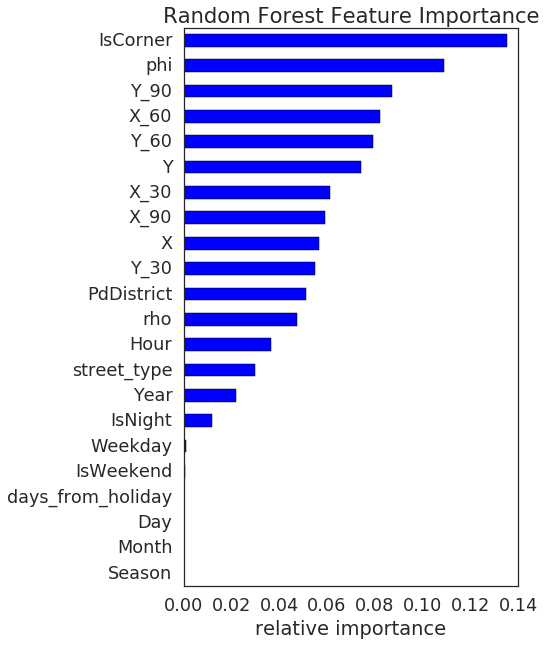

In [61]:
model_ = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=40, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=45, n_jobs=1,
            oob_score=False, random_state=139, verbose=0, warm_start=False)

model_.fit(X_train,y_train)

importances = pd.DataFrame({'value':model_.feature_importances_},index=X_train.columns.values)
imp_s = importances.sort_values('value',ascending=True)



plt.figure()
imp_s.plot(kind='barh', legend=False, figsize=(6, 10))
plt.title('Random Forest Feature Importance')
plt.xlabel('relative importance')
plt.show()

# AdaBoost

In [25]:
# tune AdaBoostClassifier

MODEL = AdaBoostClassifier(random_state=200)

SCORING = 'log_loss'

PARAMS = {'n_estimators':[75,100,125]
         }

clf = grid_search.GridSearchCV(MODEL, PARAMS, verbose=True,scoring=SCORING)
clf.fit(X_train, y_train)

print clf.best_estimator_
print clf.best_score_

# n_estimators':[50,100,150]
# Fitting 3 folds for each of 3 candidates, totalling 9 fits
# AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
#           learning_rate=1.0, n_estimators=100, random_state=200)
# -3.6756466832

Fitting 3 folds for each of 3 candidates, totalling 9 fits
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=200)
-3.6756466832


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 36.4min finished


# Submission

In [27]:
# fit model on test set

MODEL = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.55,
       gamma=0.1, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='multi:softprob', reg_alpha=100, reg_lambda=1,
       scale_pos_weight=1, seed=157, silent=True, subsample=0.7)

MODEL.fit(X_train,y_train)

# submission file

probs = MODEL.predict_proba(X_test)

probs_df = pd.DataFrame(probs,columns=[x.upper() for x in list(le2.classes_)])
probs_df.index.name = 'Id'
probs_df.reset_index(inplace=1)

probs_df.to_csv('submission.csv',index=0)

